In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader
from Source.Util.simulateToyData import ToySimulator

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runpath = "runs/AutoRegGMM_toy_9862/"

# Load data

In [3]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [7]:
data = ToySimulator(params).data
n_gauss = params["n_gauss"]

# Initialize modified model class

In [8]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Build model AutoRegGMM with n_head=2, n_per_head=8, n_blocks=2, intermediate_fac=2, n_gauss=10 with bayesian=0


<All keys matched successfully>

In [9]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [10]:
n_samples = 10
samples, xs, probs, probsindiv = model.sample_n_bonus(n_samples)
samples = samples[:,1:]

print(samples)
print(np.shape(probs), np.shape(xs), np.shape(probsindiv), np.shape(samples), np.shape(data))

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


[[ 1.0069213   1.0683459   0.98140067  1.0191838 ]
 [ 1.1118265   1.0745022   1.0754274   0.9197664 ]
 [ 0.91583717  0.82129884  0.9653993   1.0147108 ]
 [ 1.0812418   1.2262473   1.143667    0.9790115 ]
 [-0.91981804 -0.8237766  -0.868073   -1.0076689 ]
 [ 1.1643102   0.9962746   1.0309232   0.9574865 ]
 [ 1.0333368   0.99935603  1.0859456   0.83318156]
 [-0.94650567 -0.9765811  -0.9515665  -1.0827885 ]
 [-0.9643146  -0.9887221  -1.1775311  -0.9475453 ]
 [-1.1697749  -1.1725687  -1.0415645  -1.0194106 ]]
(10, 4, 1000) (4, 1000) (10, 4, 10, 1000) (10, 4) (1000000, 4)


# Test plot

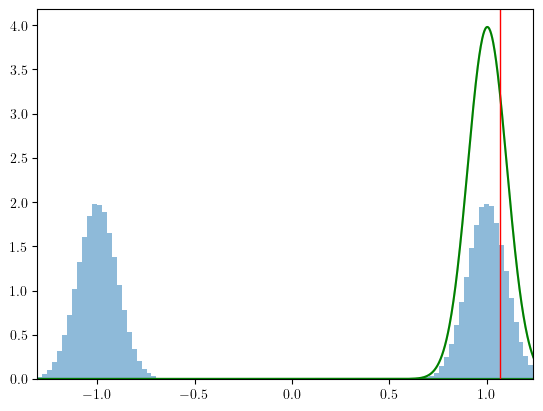

In [12]:
idim=1
isample=0
bins=100
xmin=np.min(xs[idim,:])
xmax=np.max(xs[idim,:])
plt.hist(data[:,idim], alpha=.5, bins=bins, range=(xmin, xmax), density=True, align="mid", rwidth=1.)
plt.plot(xs[idim,:], probs[isample, idim, :], color="g")
for igauss in range(n_gauss):
    plt.plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", linestyle="-", alpha=.2)
_, ymax = plt.ylim()
plt.vlines(samples[isample,idim], 0., ymax, "r", linewidth=1)
plt.xlim(xmin, xmax)
plt.ylim(0., ymax)
plt.show()

TBD
- Plot also the individual gaussians (nicer)

# Fancy plot

In [13]:
def probPlot(probs, samples, filenameOut=None, var=None, maxSamples=None, nbins=100):
    nsamples = np.shape(samples)[0]
    if(maxSamples!=None):
       nsamples = np.min([nsamples, maxSamples])
    ndim = np.shape(samples)[1]
    f, axarr = plt.subplots(nsamples, ndim, figsize=(3*ndim,3*nsamples), sharex=True,
                           gridspec_kw={"hspace": 0.})
    plt.tight_layout()
    
    ymax=np.zeros(ndim)
    for isample in range(nsamples):
        print(f"Working on sample {isample}/{nsamples}")
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            
            axarr[isample,idim].plot(xs[idim,:], probs[isample,idim,:], color="g")
            axarr[isample,idim].hist(data[:,idim], density=True, alpha=.5, range=(xmin, xmax), rwidth=1., bins=nbins, align="mid")
            for igauss in range(n_gauss):
                axarr[isample,idim].plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", alpha=.2)
            _, ymax0 = axarr[isample,idim].get_ylim()

            ymax[idim] = np.max([ymax[idim], ymax0])
            axarr[isample,idim].vlines(samples[isample,idim], 0., ymax[idim], color="r")
            if((type(var) is np.ndarray) and isample==nsamples-1):
                axarr[isample,idim].set_xlabel(r"${%s}$ bin" %var[idim])
    for isample in range(nsamples):
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            axarr[isample,idim].set_ylim(0, ymax[idim])
            #axarr[isample,idim].set_xlim(xmin, xmax)
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf")
    #plt.close()

Working on sample 0/5
1.0069213 2.172484470823313 -1.3004757165908813 1.298132061958313
1.0683459 4.178589842190582 -1.3078114986419678 1.240087628364563
0.98140067 4.180528270443752 -1.2432739734649658 1.2830625772476196
1.0191838 4.186890353645065 -1.2911275625228882 1.3139454126358032
Working on sample 1/5
1.1118265 2.172484470823313 -1.3004757165908813 1.298132061958313
1.0745022 4.182118770439116 -1.3078114986419678 1.240087628364563
1.0754274 4.180528270443752 -1.2432739734649658 1.2830625772476196
0.9197664 4.1882928882641925 -1.2911275625228882 1.3139454126358032
Working on sample 2/5
0.91583717 2.172484470823313 -1.3004757165908813 1.298132061958313
0.82129884 4.182118770439116 -1.3078114986419678 1.240087628364563
0.9653993 4.180528270443752 -1.2432739734649658 1.2830625772476196
1.0147108 4.191413682489272 -1.2911275625228882 1.3139454126358032
Working on sample 3/5
1.0812418 2.172484470823313 -1.3004757165908813 1.298132061958313
1.2262473 4.182118770439116 -1.3078114986419

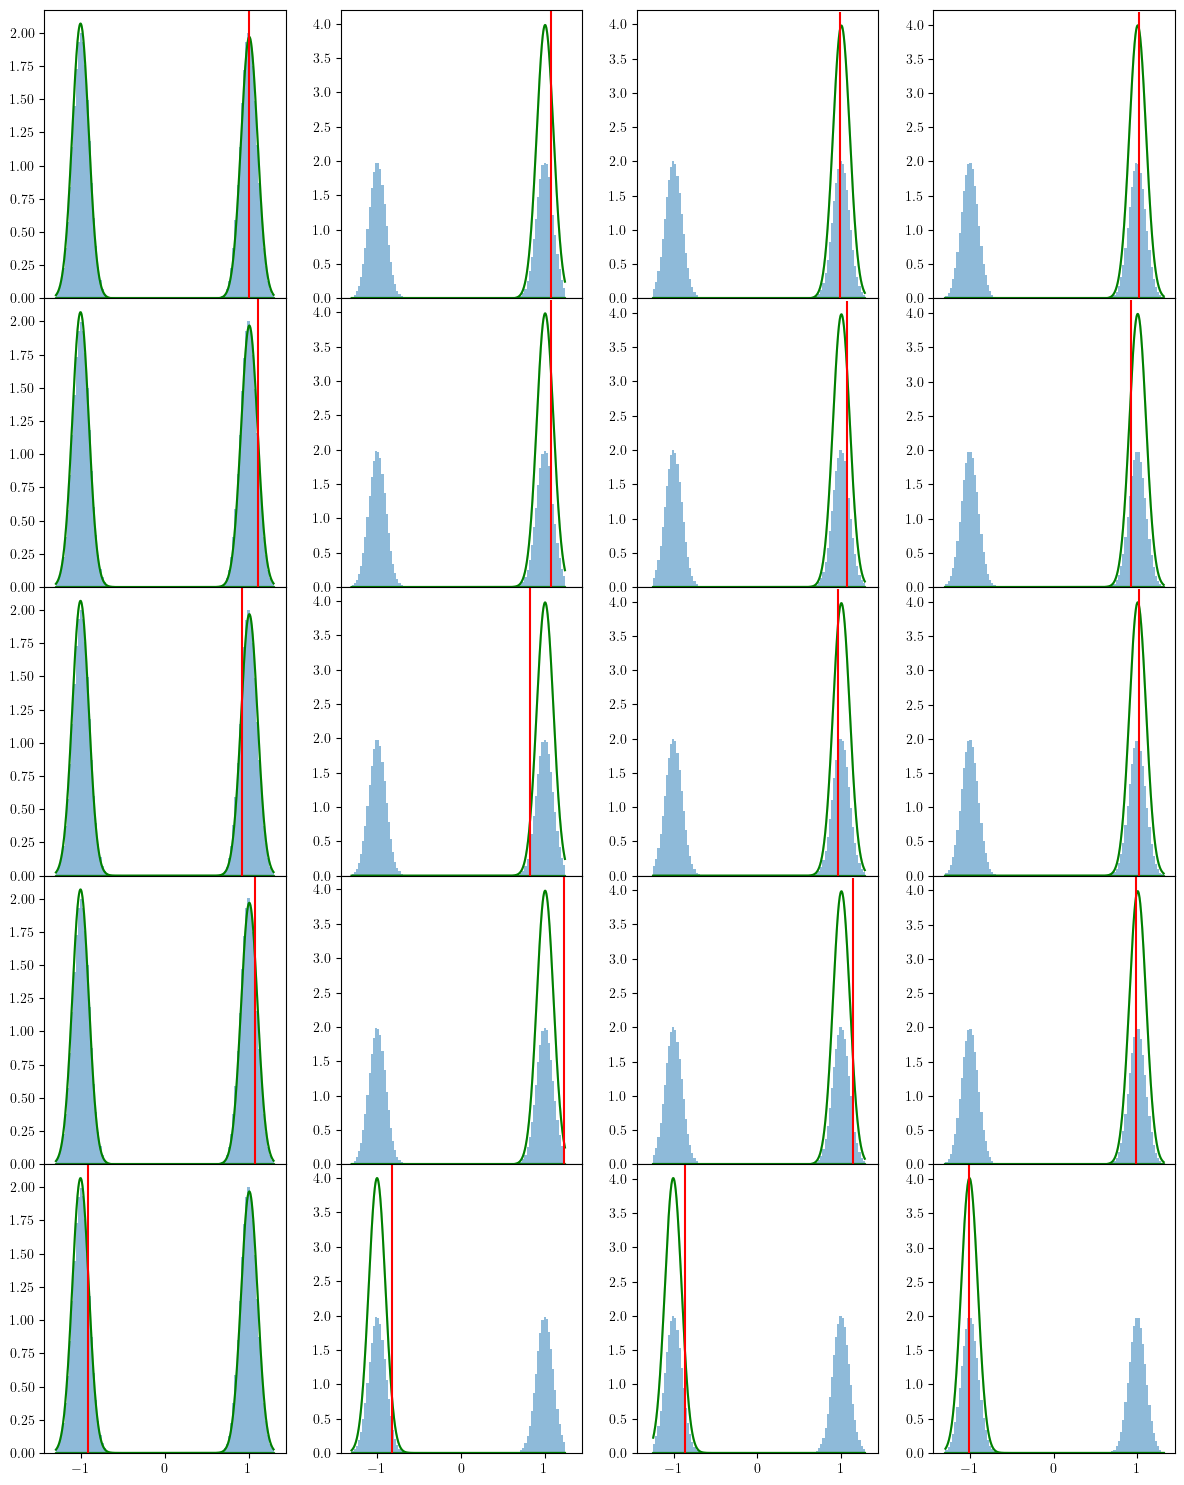

In [16]:
probPlot(probs, samples, var=None, maxSamples=5, 
         filenameOut="Scripts/test.pdf")